In [1]:
import psychopy
#from muselsl import stream, list_muses, view, record
#import mne
#from utils import utils

In [2]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
from stimulus_presentation import visual_p300_stripes
from utils import utils
from collections import OrderedDict
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


# P300

The P300 is a positive event-related potential (ERP) that occurs around 300ms after perceiving a novel or unexpected stimulus. It is most commonly elicited through 'oddball' experimental paradigms, where a certain subtype of stimulus is presented rarely amidst a background of another more common type of stimulus. Interestingly, the P300 is able to be elicited by multiple sensory modalities (e.g. visual, auditory, somatosensory). Thus, it is believed that the P300 may be a signature of higher level cognitive processing such as conscious attention.

In this notebook, we will attempt to elicit a P300 with a visual oddball stimulation paradigm using the Muse headband

## Step 1: Connect to an EEG Device
*Note: if using Windows 10 and BlueMuse, skip this section and connect using the BlueMuse GUI*

Make sure your device is turned on and run the following code. It should detect and connect to the device and begin 'Streaming...'

If the device is not found or the connection times out, try running this code again

In [3]:
# Search for available Muse devices
muses = list_muses()

Starting BlueMuse, see BlueMuse window for interactive list of devices.


In [4]:
# Start a background process that will stream data from the first available Muse
stream_process = Process(target=stream, args=(muses[0]['address'],))
stream_process.start()

TypeError: 'NoneType' object is not subscriptable

## Step 2: Apply the EEG Device and Wait for Signal Quality to Stabilize
Once your Muse is connected and streaming data, put it on and run the following code to view the raw EEG data stream.

The numbers on the side of the graph indicate the variance of the signal. Wait until this decreases below 10 for all electrodes before proceeding.

In [4]:
# On Windows, you may need to replace this with the command %matplotlib tk
%matplotlib

view()

Using matplotlib backend: Qt5Agg
Looking for an EEG stream...
Start acquiring data.

                toggle filter : d
                toogle full screen : f
                zoom out : /
                zoom in : *
                increase time scale : -
                decrease time scale : +
               


## Step 3: Run the Experiment
Modify the variables in the following code chunk to define how long you want to run the experiment and the name of the subject and session you are collecting data from.

In [5]:
# Define these parameters 
duration = 20 # in seconds. 120 is recommended
subject = 4 # unique id for each participant
session =  1# represents a data collection session. Multiple trials can be performed for each session

Seat the subject in front of the computer and run the following cell to run a single trial of the experiment.

In order to maximise the possibility of success, participants should take the experiment in a quiet environment and do their best to minimize movement that might contaminate the signal. With their jaw and face relaxed, subjects should focus on the stimuli, mentally noting when they perceive the oddball stimulus

Data will be recorded into CSV files in the `eeg-notebooks/data` directory

In [7]:
recording_path = os.path.join(os.path.expanduser("~"), "eeg-notebooks", "data", "visual", "P300", "subject" + str(subject), "session" + str(session), ("recording_%s.csv" %
                                              strftime("%Y-%m-%d-%H.%M.%S", gmtime())) + ".csv")

stimulus = Process(target=visual_p300_stripes.present, args=(duration,))
recording = Process(target=record, args=(duration, recording_path))

stimulus.start()
recording.start()

### Repeat Data Collection 3-6 times

Visualizing ERPs requires averaging the EEG response over many different rounds of stimulus presentation. Depending on experimental conditions, this may require as little as one two minute trial or as many as 6. We recommend repeating the above experiment 3-6 times before proceeding. 

Make sure to take breaks, though! Inattention, fatigue, and distraction will decrease the quality of event-related potentials.

## Step 4: Prepare the Data for Analysis

Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the N170


### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step to using MNE is to read the data we've collected into an MNE `Raw` object

In [6]:
raw = utils.load_data('visual/P300', sfreq=150., 
                      subject_nb=subject, session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   203.753 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   203.753 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   203.753 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   203.753 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   203.753 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=23208
    Range : 0 ... 23207 =      0.000 ...   154.713 secs
Ready.


### Visualizing the Power Spectrum

Plotting the power spectral density (PSD) of our dataset will give us a glimpse at the different frequencies that are present. We won't be able to see the P300 in the PSD, but it will give us an impression of how noisy our data was. A very noisy or flat PSD may represent poor signal quality at certain electrodes



Effective window size : 13.653 (s)


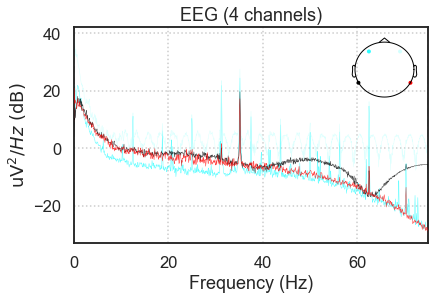

In [7]:
%matplotlib inline
raw.plot_psd();

This PSD looks good. There is a tremendous peak at 60hz. You can tell this dataset was collected in the United States because of the 60hz line noise

### Filtering

Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.

Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Effective window size : 13.653 (s)


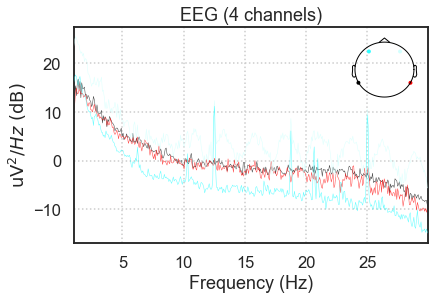

In [8]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

This PSD looks great. The AF8 electrode (Front right; light green) seems to have some noise in the signal, but the TP9 and TP10 electrodes (red and black) look great

### Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus. No baseline correction is needed (signal is bandpass filtered) and we will reject every epoch where the amplitude of the signal exceeded 75 uV, which should most eye blinks.

In [9]:
events = find_events(raw)
event_id = {'Non-Target': 1, 'Target': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

613 events found
Event IDs: [1 2]
sample drop %:  1.4681892332789603


<Epochs  |   604 events (all good), -0.1 - 0.8 sec, baseline off, ~2.5 MB, data loaded,
 'Non-Target': 519
 'Target': 85>

Sample drop % is an important metric representing how noisy our data set was. If this is greater than 20%, consider ensuring that signal variances is very low in the raw EEG viewer and collecting more data

## Step 5: Analyze the Data

Finally, we can now analyze our results by averaging the epochs that occured during the different stimuli and looking for differences in the waveform


### Epoch average

With our `plot_conditions` utility function, we can plot the average ERP for all electrodes for both conditions:

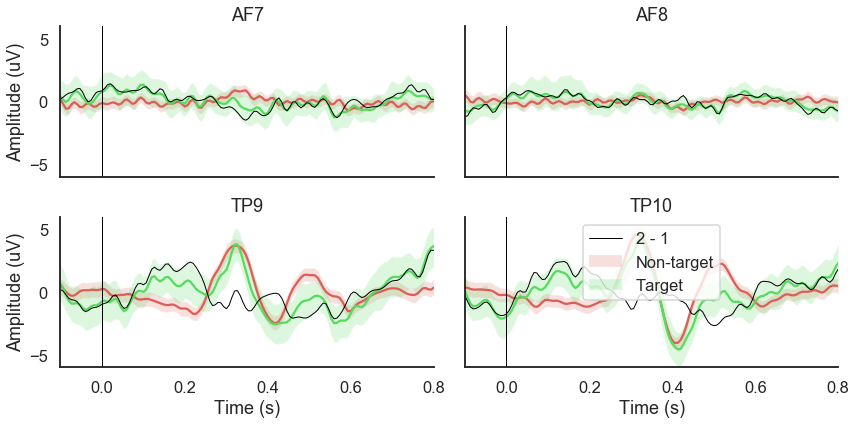

In [10]:
%matplotlib inline
conditions = OrderedDict()
conditions['Non-target'] = [1]
conditions['Target'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

Here we can see a beautiful negative deflection in the EEG around 350ms after presentation of Target stimuli. The fact that it's occuring ~50ms later than expected is probably due to delay introduced by transmitting the data over bluetooth.

But wait, isn't this supposed to be a positive ERP? Well, yes, but the Muse's reference electrode is in a different location than traditional EEG systems (at the very front of the forehead instead of the top of the head or near the ear). Because of the location of the source of the P300 signal in the brain, this means that the direction of the P300 potential is inverted

### Decoding the P300

Next, we will use 4 different machine learning pipelines to classify the P300 based on the data we collected.

- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered the standard decoding pipeline for MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very commonly used in P300 BCIs. It can outperform the previous one but become unusable if the number of dimension is too high.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

*Note: because we're doing machine learning here, the following cell may take a while to complete*

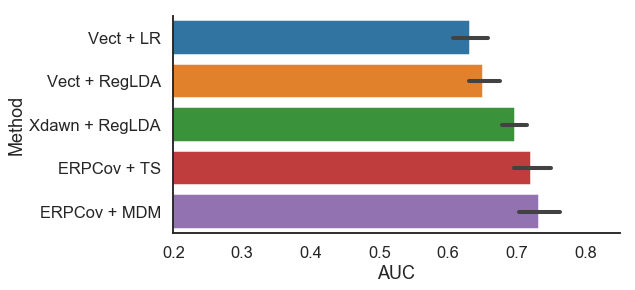

In [19]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

The best classifier for this dataset was ERP Covariance + MDM, which achieved an accuracy of around 0.77. This could be considered good enough for a BCI application, though one shouldn't expect outstanding results